# Visual experiment tests

In [1]:
import numpy as np
import ipywidgets as wd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from enum import Enum, unique, auto
from datetime import datetime

In [2]:
@unique
class Shape(Enum):
    TRIANGLE = 'triangle'
    RECTANGLE = 'rectangle'
    NOTHING = 'nothing'
    
    def get_shape(self):
        methods = {
            'triangle':self.get_triangle,
            'rectangle':self.get_rectangle,
            'nothing':self.get_nothing
        }
        return methods[self.value]
    
    @staticmethod
    def get_line():
        x = np.random.rand(2, 2)
        while(np.linalg.norm(x[:,0]-x[:,1]) < .3):
            x = np.random.rand(2, 2)
        return x
    
    @staticmethod
    def get_orthogonal(x):
        x_m = np.linalg.norm(x)
        y = np.random.rand(2)
        y = y - np.dot(x/x_m, y) * x/x_m
        return y/np.linalg.norm(y)
    
    def get_rectangle(self):
        x = self.get_line()
        y = self.get_orthogonal(x[:,0]-x[:,1])*(np.random.rand(1)/2+0.3)
        y1, y2 = (x[:,0]+y).reshape(-1, 1), (x[:,1]+y).reshape(-1, 1)
        x = np.concatenate([y1, x, y2], axis=1)
        return x
    
    def get_triangle(self):
        x = self.get_line()
        y = self.get_orthogonal(x[:,0]-x[:,1])*(np.random.rand(1)/2+0.3)
        y = (x[:,0]+x[:,1])/2 + y
        x = np.append(x, y.reshape(2, 1), axis=1)
        return x
    
    def get_nothing(self):
        return np.asarray([[], []])


In [3]:
class FigureManager():
    def __init__(self, shape=(12,9), s=60, a=0.6, color='b', size=300):
        self.shapes = list(Shape)
        self.figsize = shape
        self.s, self.a, self.color = s, a, color
        self.num_of_points = size
        self.generated_shapes, self.guessed_shapes, self.response_times = *np.asarray([[],[],[]]),
        self.current = None
        self.incorrect = []
        self.show_lines = False
    
    # Method used to create a scatter plot of random points with hidden shape
    def create_shape(self):
        shape = self.choose_shape()
        for s in self.shapes:
            if s == shape:
                x = self.generate_points(shape.get_shape())
        noise = np.random.rand(2, self.num_of_points)
        self.current = {'noise':noise, 'fig':x, 'real':shape.value, 'time':datetime.now()}
        self.generated_shapes = np.append(self.generated_shapes, shape)
        self.plot_figure(noise, x)
        plt.show()
    
    def choose_shape(self): 
        return self.shapes[np.random.randint(0, len(self.shapes))]
    
    # Makes sure none of the points constituting the shape are too close to the edge
    def generate_points(self, func):
        x = func()
        while any(x.reshape(-1) > .9) or any(x.reshape(-1) < .1):
            x = func()
        return x
    
    def add_answer(self, answer):
        self.current['time'] = (datetime.now() - self.current['time']).total_seconds()
        # If incorrect, add to incorrect guess list
        if answer.value != self.current['real']:
            self.current['guess'] = answer.value
            self.incorrect.append(self.current)
        self.guessed_shapes = np.append(self.guessed_shapes, answer)
        self.response_times = np.append(self.response_times, self.current['time'])
        
    def results(self):
        print(f"Accuracy: {self.get_score():.3f}")
        if len(self.response_times) > 0:
            print(f"Mean response time: {self.response_times.mean():.3f}")
            print(f"Response time standard deviation: {self.response_times.std():.3f}")
        
        if len(self.incorrect) > 0: self.show_incorrect()
    
    def get_score(self):
        if len(self.guessed_shapes) > 0:
            return sum(self.generated_shapes[:-1] == self.guessed_shapes)/len(self.guessed_shapes)
        return 0
    
    def clear_score(self):
        self.generated_shapes = np.asarray([self.generated_shapes[-1]])
        self.guessed_shapes, self.response_times = *np.asarray([[],[]]),
        self.incorrect = []
    
    def show_incorrect(self):
        _, axs = plt.subplots(len(self.incorrect), 2, figsize=(26, 10*len(self.incorrect)))
        axs = axs.reshape(-1, 2)
        self.show_lines = False
        self.show_figures(axs[:,0], 'guess', template='Guessed: {}')
        self.show_lines = True
        self.show_figures(axs[:,1], 'real', template='Real answer: {}')
        plt.show()
            
    def show_figures(self, axs, title_key, template="{}", font_size=24):
        for incorrect, ax in zip(self.incorrect, axs):
                self.plot_figure(incorrect['noise'], incorrect['fig'], fig=ax)
                ax.set_title(template.format(incorrect[title_key]), size=font_size)
    
    # The lines connect the 'hidden' points constituting the shape
    @staticmethod
    def draw_lines(fig, x):
        size = x.shape[-1]
        for i in range(size):
            i = (np.arange(2) + i)%size
            fig.plot(x[0,i], x[1,i], linewidth=2, color='r')

    def plot_figure(self, noise, x, fig=None):
        if fig is None: _, fig = plt.subplots(1, 1, figsize=self.figsize)
        fig.scatter(*noise, color=self.color, alpha=self.a)
        fig.scatter(*x, color=self.color, s=self.s)
        if self.show_lines: self.draw_lines(fig, x)
        fig.axis('off')

In [4]:
class Experiment:
    def __init__(self, mode='debug', **kwargs):
        self.fm = FigureManager()
        self.create_experiment(mode, **kwargs)
        self.begin_button = wd.Button(description="Begin")
        self.output = wd.Output()
        self.begin_button.on_click(self.begin)
        display(self.begin_button)
        display(self.output)
    
    def begin(self, b):
        with self.output:
            self.begin_button.layout.display = 'none'
            self.begin_experiment()
    
    def create_experiment(self, mode, **kwargs):
        pass
    
    def begin_experiment(self):
        buttons = [wd.Button(description=label) for label in ["Triangle", "Rectangle", "Nothing"]]
        lines = wd.Checkbox(description="Lines", indent=False)
        self.output = wd.Output()
        display(lines, self.output, wd.HBox(buttons))
        
        for button, func in zip(buttons, ['triangle', 'rectangle', 'nothing']):
            button.on_click(getattr(self, f"{func}_button_clicked"))
        lines.observe(self.line_switch)
        
        with self.output: self.fm.create_shape()        

    def line_switch(self, b):
        if type(b['new']) == bool: self.fm.show_lines = b['new']
    
    def button_clicked(self, shape):
        with self.output:
            clear_output()
            self.fm.add_answer(shape)
            self.fm.create_shape()
    
    def triangle_button_clicked(self, b):
        self.button_clicked(Shape.TRIANGLE)

    def rectangle_button_clicked(self, b):
        self.button_clicked(Shape.RECTANGLE)

    def nothing_button_clicked(self, b):
        self.button_clicked(Shape.NOTHING)

e = Experiment()

Button(description='Begin', style=ButtonStyle())

Output()

Accuracy: 0.727
Mean response time: 2.034
Response time standard deviation: 0.624


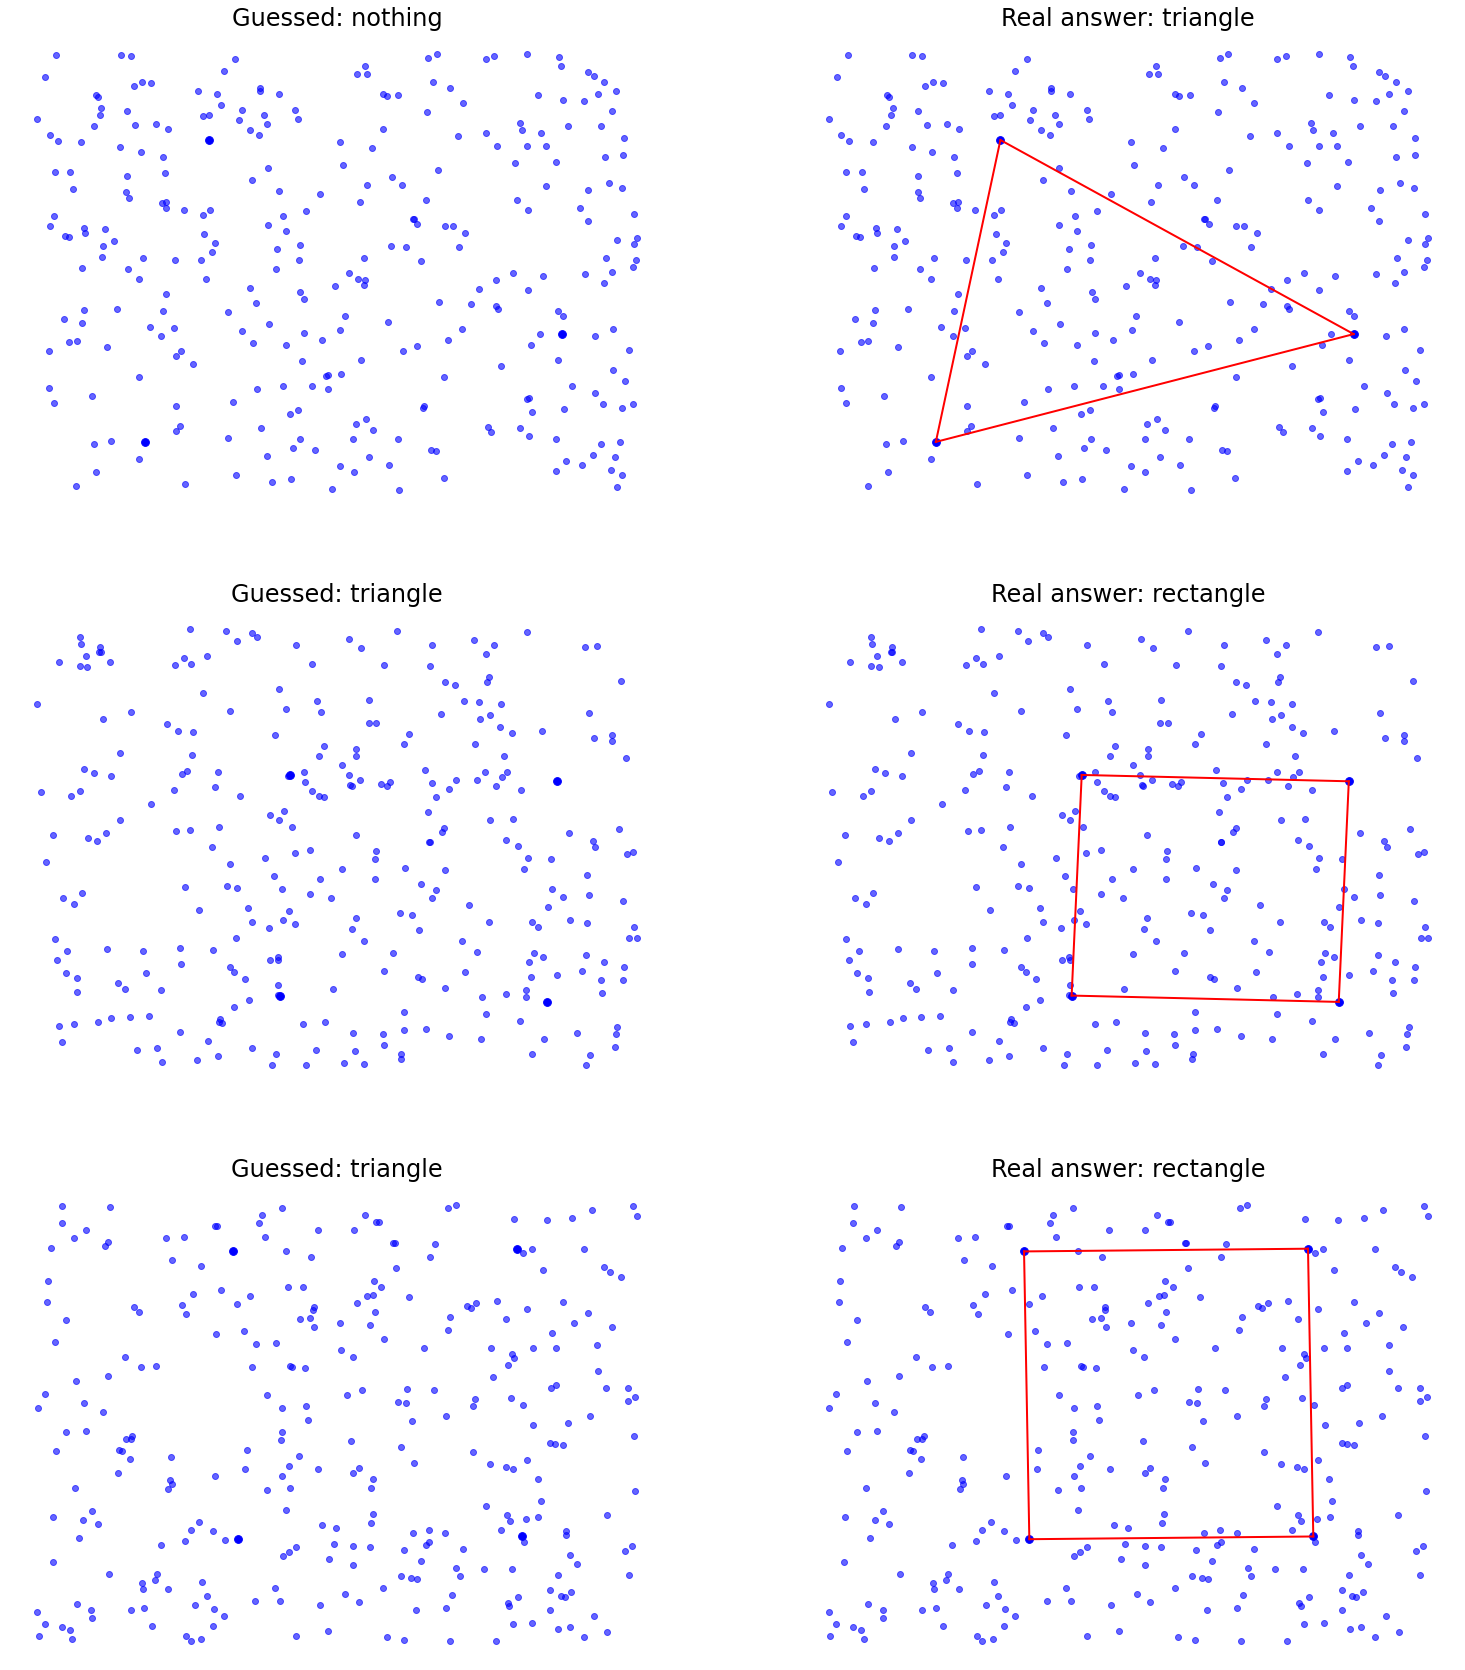

In [5]:
e.fm.results()